# INSTRUCTIONS
* [RUN THIS KERNEL](https://www.kaggle.com/nazmuddhohaansary/gcspath-for-rice-leaf-9-class-data)
* Collect The GCS PATH: such as 

```'gs://kds-33dc5d420bc7282a4b7955000de5511010e42953a4fb70942d1b0112'```
* Set The GCS_PATH="The value we got"

In [1]:
GCS_PATH='gs://kds-fb847d85135ef53947822a9fe678b5606ca7ce2f71ab57be50d5dba2' # @param

# Installations

In [2]:
from IPython.display import clear_output
!pip install -U image-classifiers
!pip install -U efficientnet
clear_output()

# Mount Drive 
* change working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis

/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis


In [5]:
ls -la

total 13
-rw------- 1 root root  249 Jan  7 08:38 config.json
drwx------ 2 root root 4096 Jan 13 15:58 Ensemble/
drwx------ 2 root root 4096 Jan  7 08:37 models/
drwx------ 2 root root 4096 Jan 18 17:02 MODELS/


# PARAMETERS


In [6]:
import os 
from glob import glob 
MODELS=[_path for _path in glob(os.path.join(os.getcwd(),"MODELS","*.*"))]
DATA_FOLDER =    "content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords"
print("--------------------AVAILABLE MODELS----------------------------------------------")
print("----------------------------------------------------------------------------------")
model_names=[]
for MODEL in MODELS:
  model_name=os.path.basename(MODEL).split(".")[0]
  print(model_name)
  model_names.append(model_name)
  print("----------------------------------------------------------------------------------")
MODEL_NAME="_".join(model_names)
MODEL_NAME="ensamble_"+MODEL_NAME
print(MODEL_NAME)

--------------------AVAILABLE MODELS----------------------------------------------
----------------------------------------------------------------------------------
densenet201
----------------------------------------------------------------------------------
inceptionresnetv2
----------------------------------------------------------------------------------
xception
----------------------------------------------------------------------------------
ensamble_densenet201_inceptionresnetv2_xception


In [7]:
import os 
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048  
MODEL_DIR   =    os.path.join(os.getcwd(),"Ensemble",f'{MODEL_NAME}') 
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,"model.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}/'

print(GCS_PATH)
print(WEIGHT_PATH)
print(MODEL_DIR)



gs://kds-fb847d85135ef53947822a9fe678b5606ca7ce2f71ab57be50d5dba2/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords/
/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/Ensemble/ensamble_densenet201_inceptionresnetv2_xception/model.h5
/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/Ensemble/ensamble_densenet201_inceptionresnetv2_xception


# Config Reading

In [8]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['covid_19', 'normal', 'pneumonia', 'tuberculosis'],
 'nb_channels': 3,
 'nb_classes': 4,
 'nb_eval_data': 7194,
 'nb_train_data': 18180}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [9]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.9.2
Running on TPU  grpc://10.35.135.2:8470


REPLICAS:  8


## Training Params

In [10]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

142 56


## Data input function

In [11]:
from classification_models.tfkeras import Classifiers
import efficientnet.tfkeras as efn

def get_model(model_path):
  model_name=os.path.basename(model_path).split(".")[0]
  if "EfficientNet" not in model_name:
    classifier, _ = Classifiers.get(model_name)
  else:
    classifier=getattr(efn,model_name)
  net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False,weights=None)
  for layer in net.layers:
      layer.trainable = False
  
  inp=net.input
  x=net.output
  x=tf.keras.layers.GlobalAveragePooling2D()(x)
  x=tf.keras.layers.Dropout(0.1)(x)
  x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
  model=tf.keras.Model(inputs=inp,outputs=x)
  model.load_weights(model_path)
  print(f"Loaded:{model_path}")
  return model,model_name

def ensamble_model(model_paths):
  models=[]
  names=[]
  for model_path in model_paths:
    model,mname=get_model(model_path)
    models.append(model)
    names.append(mname)
  ensamble_inputs=[model.input for model in models]
  ensamble_outputs=[model.output for model in models]
  merge=tf.keras.layers.Concatenate()(ensamble_outputs)
  out=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(merge)
  model=tf.keras.models.Model(inputs=ensamble_inputs,outputs=out)
  print(ensamble_inputs)
  return model

with strategy.scope():
    model=ensamble_model(MODELS)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

Loaded:/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/MODELS/densenet201.h5
Loaded:/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/MODELS/inceptionresnetv2.h5
Loaded:/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/MODELS/xception.h5
[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>]


In [12]:
names=[]
for n in model.inputs:
  names.append(n.name)
  print(n.name) 
#model.get_layer(index =1).name

input_1
input_2
input_3


In [13]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        images={}
        for model_name in names:
          images[model_name]=image
        return images,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

dict_keys(['input_1', 'input_2', 'input_3'])
input_1
(128, 256, 256, 3)


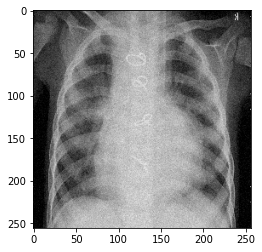

Exception ignored in: <function Executor.__del__ at 0x7f8fe8f08ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 4)
['covid_19', 'normal', 'pneumonia', 'tuberculosis']
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
  print(x.keys())
  for model_name in names:
      print(model_name)
      print(x[f"{model_name}"].shape)
      data=np.squeeze(x[f"{model_name}"][0])
      plt.imshow(data)
      plt.show()
      print('Image Batch Shape:',x[f"{model_name}"].shape)
      print('Target Batch Shape:',y.shape)
      print(LABELS)
      print(y[0])
      break

# MODEL definition


## Callbacks
**CHANGABLE**

In [15]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [16]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
142/142 [==============================] - ETA: 0s - loss: 1.3020 - accuracy: 0.4437
Epoch 1: val_loss improved from inf to 1.02069, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/Ensemble/ensamble_densenet201_inceptionresnetv2_xception/model.h5
142/142 [==============================] - 192s 837ms/step - loss: 1.3020 - accuracy: 0.4437 - val_loss: 1.0207 - val_accuracy: 0.6394 - lr: 1.0000e-04
Epoch 2/250
142/142 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.6455
Epoch 2: val_loss improved from 1.02069 to 0.85387, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/Ensemble/ensamble_densenet201_inceptionresnetv2_xception/model.h5
142/142 [==============================] - 63s 442ms/step - loss: 0.8584 - accuracy: 0.6455 - val_loss: 0.8539 - val_accuracy: 0.6377 - lr: 1.0000e-04
Epoch 3/250
142/142 [==============================] 

## Model history

# Results



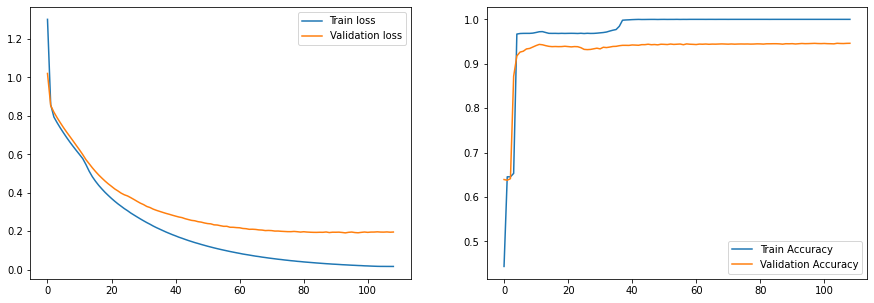

In [17]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig( os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [18]:
model.load_weights(WEIGHT_PATH)
test_ds   =   data_input_fn("test")
result = model.evaluate(test_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

56/56 [==============================] - 14s 185ms/step - loss: 0.1259 - accuracy: 0.9711


{'loss': 0.12586358189582825, 'accuracy': 0.9711216688156128}

In [19]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/56 [00:00<?, ?it/s]

4/4 [==============================] - 1s 123ms/step


Exception ignored in: <function Executor.__del__ at 0x7f8fe8f08ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


# Saving

In [20]:
from sklearn.metrics import classification_report
report =classification_report(gts, preds, target_names=LABELS,output_dict=True)
report

{'covid_19': {'precision': 0.8305084745762712,
  'recall': 0.42424242424242425,
  'f1-score': 0.5616045845272206,
  'support': 231},
 'normal': {'precision': 0.9383802816901409,
  'recall': 0.9217466493731085,
  'f1-score': 0.9299890948745911,
  'support': 2313},
 'pneumonia': {'precision': 0.9890398947829899,
  'recall': 0.9770463404071026,
  'f1-score': 0.9830065359477125,
  'support': 2309},
 'tuberculosis': {'precision': 0.9167000400480577,
  'recall': 0.988768898488121,
  'f1-score': 0.9513715710723193,
  'support': 2315},
 'accuracy': 0.9451729910714286,
 'macro avg': {'precision': 0.918657172774365,
  'recall': 0.8279510781276891,
  'f1-score': 0.8564929466054608,
  'support': 7168},
 'weighted avg': {'precision': 0.9442208090041283,
  'recall': 0.9451729910714286,
  'f1-score': 0.9421013830924113,
  'support': 7168}}

In [21]:
import json
with open(os.path.join(MODEL_DIR,f"report_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(report, fp)

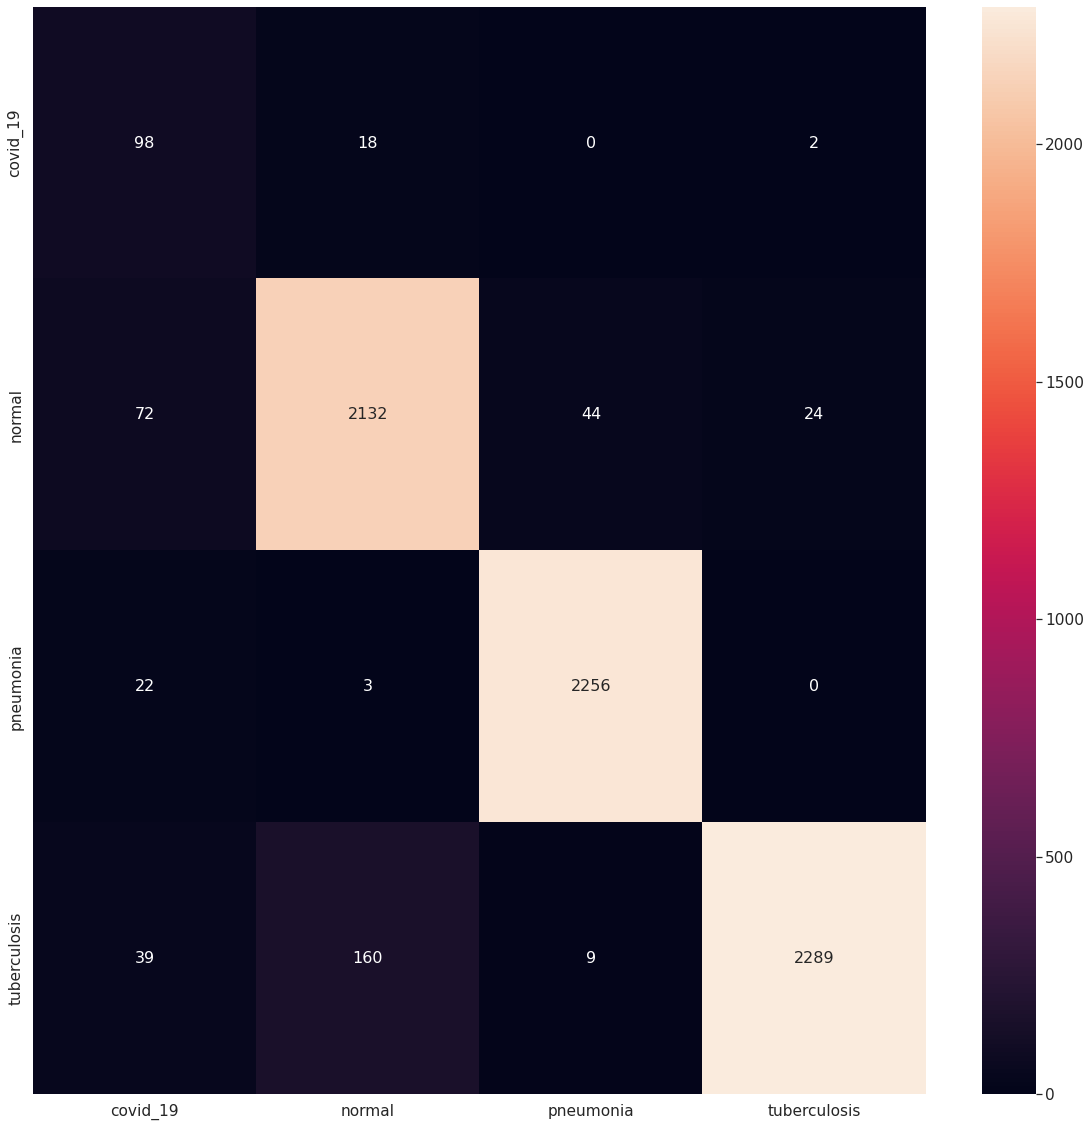

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat, 
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()